# Handwritten Digit Recognition

In this tutorial, we'll give you a step by step walk-through of how to build a hand-written digit classifier using the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. For someone new to deep learning, this exercise is arguably the "Hello World" equivalent.

MNIST is a widely used dataset for the hand-written digit classification task. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). The task at hand is to train a model using the 60,000 training images and subsequently test its classification accuracy on the 10,000 test images.

![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/mnist.png)

**Figure 1:** Sample images from the MNIST dataset.

## Prerequisites
To complete this tutorial, we need:  

- MXNet version 0.10 or later. See the installation instructions for your operating system in [Setup and Installation](http://mxnet.io/get_started/install.html).

- [Python Requests](http://docs.python-requests.org/en/master/) and [Jupyter Notebook](http://jupyter.org/index.html).

```
$ pip install requests jupyter
```

## Loading Data

Before we define the model, let's first fetch the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

The following source code downloads and loads the images and the corresponding labels into memory.

In [1]:
import mxnet as mx
mnist = mx.test_utils.get_mnist()

/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


After running the above source code, the entire MNIST dataset should be fully loaded into memory. Note that for large datasets it is not feasible to pre-load the entire dataset first like we did here. What is needed is a mechanism by which we can quickly and efficiently stream data directly from the source. MXNet Data iterators come to the rescue here by providing exactly that. Data iterator is the mechanism by which we feed input data into an MXNet training algorithm and they are very simple to initialize and use and are optimized for speed. During training, we typically process training samples in small batches and over the entire training lifetime will end up processing each training example multiple times. In this tutorial, we'll configure the data iterator to feed examples in batches of 100. Keep in mind that each example is a 28x28 grayscale image and the corresponding label.

Image batches are commonly represented by a 4-D array with shape `(batch_size, num_channels, width, height)`. For the MNIST dataset, since the images are grayscale, there is only one color channel. Also, the images are 28x28 pixels, and so each image has width and height equal to 28. Therefore, the shape of input is `(batch_size, 1, 28, 28)`. Another important consideration is the order of input samples. When feeding training examples, it is critical that we don't feed samples with the same label in succession. Doing so can slow down training.
Data iterators take care of this by randomly shuffling the inputs. Note that we only need to shuffle the training data. The order does not matter for test data.

The following source code initializes the data iterators for the MNIST dataset. Note that we initialize two iterators: one for train data and one for test data.

In [3]:
batch_size = 128
train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

## Training
We will cover a couple of approaches for performing the hand written digit recognition task. The first approach makes use of a traditional deep neural network architecture called Multilayer Percepton (MLP). We'll discuss its drawbacks and use that as a motivation to introduce a second more advanced approach called Convolution Neural Network (CNN) that has proven to work very well for image classification tasks.

### Multilayer Perceptron

The first approach makes use of a [Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) to solve this problem. We'll define the MLP using MXNet's symbolic interface. We begin by creating a place holder variable for the input data. When working with an MLP, we need to flatten our 28x28 images into a flat 1-D structure of 784 (28 * 28) raw pixel values. The order of pixel values in the flattened vector does not matter as long as we are being consistent about how we do this across all images.

In [4]:
data = mx.sym.var('data')
# Flatten the data from 4-D shape into 2-D (batch_size, num_channel*width*height)
data = mx.sym.flatten(data=data)

One might wonder if we are discarding valuable information by flattening. That is indeed true and we'll cover this more when we talk about convolutional neural networks where we preserve the input shape. For now, we'll go ahead and work with flattened images.

MLPs contains several fully connected layers. A fully connected layer or FC layer for short, is one where each neuron in the layer is connected to every neuron in its preceding layer. From a linear algebra perspective, an FC layer applies an [affine transform](https://en.wikipedia.org/wiki/Affine_transformation) to the *n x m* input matrix *X* and outputs a matrix *Y* of size *n x k*, where *k* is the number of neurons in the FC layer. *k* is also referred to as the hidden size. The output *Y* is computed according to the equation *Y = W X + b*. The FC layer has two learnable parameters, the *m x k* weight matrix *W* and the *m x 1* bias vector *b*.


In an MLP, the outputs of most FC layers are fed into an activation function, which applies an element-wise non-linearity. This step is critical and it gives neural networks the ability to classify inputs that are not linearly separable. Common choices for activation functions are sigmoid, tanh, and [rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) (ReLU). In this example, we'll use the ReLU activation function which has several desirable properties and is typically considered a default choice.

The following code declares two fully connected layers with 128 and 64 neurons each. Furthermore, these FC layers are sandwiched between ReLU activation layers each one responsible for performing an element-wise ReLU transformation on the FC layer output.

In [9]:
# The first fully-connected layer and the corresponding activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")
act1 = mx.sym.Dropout(data=act1, p=0.5)

# The second fully-connected layer and the corresponding activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")
act2 = mx.sym.Dropout(data=act2, p=0.5)

The last fully connected layer often has its hidden size equal to the number of output classes in the dataset. The activation function for this layer will be the softmax function. The Softmax layer maps its input to a probability score for each class of output. During the training stage, a loss function computes the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) between the probability distribution (softmax output) predicted by the network and the true probability distribution given by the label.

The following source code declares the final fully connected layer of size 10. 10 incidentally is the total number of digits. The output from this layer is fed into a `SoftMaxOutput` layer that performs softmax and cross-entropy loss computation in one go. Note that loss computation only happens during training.

In [10]:
# MNIST has 10 classes
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=10)
# Softmax with cross entropy loss
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

**Figure 2:** MLP network architecture for MNIST.

Now that both the data iterator and neural network are defined, we can commence training. Here we'll employ the `module` feature in MXNet which provides a high-level abstraction for running training and inference on predefined networks. The module API allows the user to specify appropriate parameters that control how the training proceeds.

The following source code initializes a module to train the MLP network we defined above. For our training, we will make use of the stochastic gradient descent (SGD) optimizer. In particular, we'll be using mini-batch SGD. Standard SGD processes train data one example at a time. In practice, this is very slow and one can speed up the process by processing examples in small batches. In this case, our batch size will be 100, which is a reasonable choice. Another parameter we select here is the learning rate, which controls the step size the optimizer takes in search of a solution. We'll pick a learning rate of 0.1, again a reasonable choice. Settings such as batch size and learning rate are what are usually referred to as hyper-parameters. What values we give them can have a great impact on training performance. For the purpose of this tutorial, we'll start with some reasonable and safe values. In other tutorials, we'll discuss how one might go about finding a combination of hyper-parameters for optimal model performance.

Typically, one runs the training until convergence, which means that we have learned a good set of model parameters (weights + biases) from the train data. For the purpose of this tutorial, we'll run training for 10 epochs and stop. An epoch is one full pass over the entire train data.

In [12]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
# create a trainable module on CPU
mlp_model = mx.mod.Module(symbol=mlp, context=mx.gpu())
mlp_model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='sgd',  # use SGD to train
              optimizer_params={'learning_rate':0.1},  # use fixed learning rate
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 100), # output progress for each 100 data batches
              num_epoch=20)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [100]	Speed: 105177.24 samples/sec	accuracy=0.113011
INFO:root:Epoch[0] Batch [200]	Speed: 131002.28 samples/sec	accuracy=0.109844
INFO:root:Epoch[0] Batch [300]	Speed: 130308.47 samples/sec	accuracy=0.111172
INFO:root:Epoch[0] Batch [400]	Speed: 128099.69 samples/sec	accuracy=0.109766
INFO:root:Epoch[0] Train-accuracy=0.117188
INFO:root:Epoch[0] Time cost=0.495
INFO:root:Epoch[0] Validation-accuracy=0.113726
INFO:root:Epoch[1] Batch [100]	Speed: 125401.97 samples/sec	accuracy=0.164140
INFO:root:Epoch[1] Batch [200]	Speed: 131653.77 samples/sec	accuracy=0.290938
INFO:root:Epoch[1] Batch [300]	Speed: 126088.49 samples/sec	accuracy=0.462734
INFO:root:Epoch[1] Batch [400]	Speed: 132213.37 samples/sec	accuracy=0.601094
INFO:root:Epoch[1] Train-accuracy=0.693359
INFO:root:Epoch[1] Time cost=0.481
INFO:root:Epoch[1] Validation-accuracy=0.795491
INFO:root:Epoch[2] Batch [100]	Speed: 126361.22 samples/sec	accuracy=0.734994
INFO:root:Epoch[2] Batch [200]	Speed: 131121.6

INFO:root:Epoch[18] Train-accuracy=0.947266
INFO:root:Epoch[18] Time cost=0.600
INFO:root:Epoch[18] Validation-accuracy=0.970728
INFO:root:Epoch[19] Batch [100]	Speed: 139226.04 samples/sec	accuracy=0.942064
INFO:root:Epoch[19] Batch [200]	Speed: 137023.63 samples/sec	accuracy=0.951562
INFO:root:Epoch[19] Batch [300]	Speed: 134472.89 samples/sec	accuracy=0.945547
INFO:root:Epoch[19] Batch [400]	Speed: 138610.29 samples/sec	accuracy=0.949453
INFO:root:Epoch[19] Train-accuracy=0.948759
INFO:root:Epoch[19] Time cost=0.441
INFO:root:Epoch[19] Validation-accuracy=0.970036


### Prediction

After the above training completes, we can evaluate the trained model by running predictions on test data. The following source code computes the prediction probability scores for each test image. *prob[i][j]* is the probability that the *i*-th test image contains the *j*-th output class.

In [13]:
test_iter = mx.io.NDArrayIter(mnist['test_data'], None, batch_size)
prob = mlp_model.predict(test_iter)
assert prob.shape == (10000, 10)

Since the dataset also has labels for all test images, we can compute the accuracy metric as follows:

In [14]:
test_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)
# predict accuracy of mlp
acc = mx.metric.Accuracy()
mlp_model.score(test_iter, acc)
print(acc)
assert acc.get()[1] > 0.96

EvalMetric: {'accuracy': 0.97003560126582278}


If everything went well, we should see an accuracy value that is around 0.96, which means that we are able to accurately predict the digit in 96% of test images. This is a pretty good result. But as we will see in the next part of this tutorial, we can do a lot better than that.

### Convolutional Neural Network

Earlier, we briefly touched on a drawback of MLP when we said we need to discard the input image's original shape and flatten it as a vector before we can feed it as input to the MLP's first fully connected layer. Turns out this is an important issue because we don't take advantage of the fact that pixels in the image have natural spatial correlation along the horizontal and vertical axes. A convolutional neural network (CNN) aims to address this problem by using a more structured weight representation. Instead of flattening the image and doing a simple matrix-matrix multiplication, it employs one or more convolutional layers that each performs a 2-D convolution on the input image.

A single convolution layer consists of one or more filters that each play the role of a feature detector. During training, a CNN learns appropriate representations (parameters) for these filters. Similar to MLP, the output from the convolutional layer is transformed by applying a non-linearity. Besides the convolutional layer, another key aspect of a CNN is the pooling layer. A pooling layer serves to make the CNN translation invariant: a digit remains the same even when it is shifted left/right/up/down by a few pixels. A pooling layer reduces a *n x m* patch into a single value to make the network less sensitive to the spatial location. Pooling layer is always included after each conv (+ activation) layer in the CNN.

The following source code defines a convolutional neural network architecture called LeNet. LeNet is a popular network known to work well on digit classification tasks. We will use a slightly different version from the original LeNet implementation, replacing the sigmoid activations with tanh activations for the neurons

In [15]:
data = mx.sym.var('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/conv_mnist.png)

**Figure 3:** First conv + pooling layer in LeNet.

Now we train LeNet with the same hyper-parameters as before. Note that, if a GPU is available, we recommend using it. This greatly speeds up computation given that LeNet is more complex and compute-intensive than the previous multilayer perceptron. To do so, we only need to change `mx.cpu()` to `mx.gpu()` and MXNet takes care of the rest. Just like before, we'll stop training after 10 epochs.

In [27]:
%%time

# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=lenet, context=mx.gpu())
# train with the same
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01, 'momentum':0.95},
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=25)

INFO:root:Epoch[0] Train-accuracy=0.111203
INFO:root:Epoch[0] Time cost=1.258
INFO:root:Epoch[0] Validation-accuracy=0.113726
INFO:root:Epoch[1] Train-accuracy=0.584372
INFO:root:Epoch[1] Time cost=2.085
INFO:root:Epoch[1] Validation-accuracy=0.948972
INFO:root:Epoch[2] Train-accuracy=0.964003
INFO:root:Epoch[2] Time cost=2.066
INFO:root:Epoch[2] Validation-accuracy=0.977453
INFO:root:Epoch[3] Train-accuracy=0.979644
INFO:root:Epoch[3] Time cost=2.073
INFO:root:Epoch[3] Validation-accuracy=0.984573
INFO:root:Epoch[4] Train-accuracy=0.985091
INFO:root:Epoch[4] Time cost=2.064
INFO:root:Epoch[4] Validation-accuracy=0.986650
INFO:root:Epoch[5] Train-accuracy=0.988040
INFO:root:Epoch[5] Time cost=2.065
INFO:root:Epoch[5] Validation-accuracy=0.987540
INFO:root:Epoch[6] Train-accuracy=0.990322
INFO:root:Epoch[6] Time cost=2.065
INFO:root:Epoch[6] Validation-accuracy=0.988331
INFO:root:Epoch[7] Train-accuracy=0.991938
INFO:root:Epoch[7] Time cost=2.068
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 1min 11s, sys: 7.98 s, total: 1min 19s
Wall time: 56.8 s


### Prediction

Finally, we'll use the trained LeNet model to generate predictions for the test data.

In [21]:
test_iter = mx.io.NDArrayIter(mnist['test_data'], None, batch_size)
prob = lenet_model.predict(test_iter)
test_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)
# predict accuracy for lenet
acc = mx.metric.Accuracy()
lenet_model.score(test_iter, acc)
print(acc)
assert acc.get()[1] > 0.98

EvalMetric: {'accuracy': 0.99001186708860756}


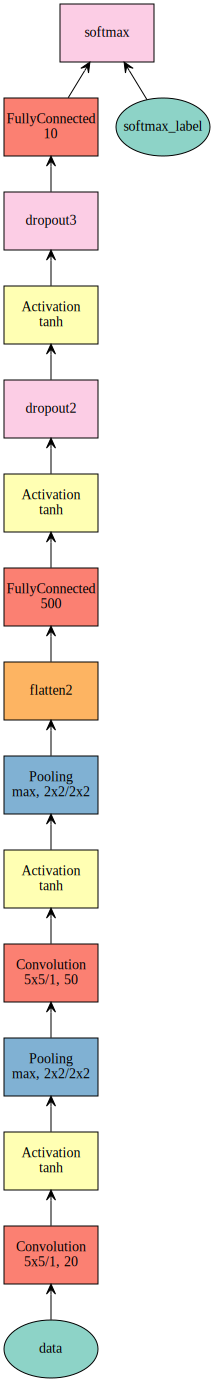

In [28]:
data = mx.sym.var('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
tanh3 = mx.sym.Dropout(data=tanh3, p=0.5)

fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=500)
tanh4 = mx.sym.Activation(data=tanh3, act_type="tanh")
tanh4 = mx.sym.Dropout(data=tanh4, p=0.5)

fc3 = mx.sym.FullyConnected(data=tanh4, num_hidden=10)
# softmax loss
lenetd = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

mx.viz.plot_network(lenetd)

In [30]:
%%time

# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=lenetd, context=mx.gpu())
# train with the same
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01, 'momentum':0.97},
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=25)

INFO:root:Epoch[0] Train-accuracy=0.273371
INFO:root:Epoch[0] Time cost=2.181
INFO:root:Epoch[0] Validation-accuracy=0.898932
INFO:root:Epoch[1] Train-accuracy=0.934102
INFO:root:Epoch[1] Time cost=2.160
INFO:root:Epoch[1] Validation-accuracy=0.975870
INFO:root:Epoch[2] Train-accuracy=0.966301
INFO:root:Epoch[2] Time cost=2.147
INFO:root:Epoch[2] Validation-accuracy=0.983782
INFO:root:Epoch[3] Train-accuracy=0.974330
INFO:root:Epoch[3] Time cost=2.155
INFO:root:Epoch[3] Validation-accuracy=0.986254
INFO:root:Epoch[4] Train-accuracy=0.978778
INFO:root:Epoch[4] Time cost=2.131
INFO:root:Epoch[4] Validation-accuracy=0.988034
INFO:root:Epoch[5] Train-accuracy=0.981726
INFO:root:Epoch[5] Time cost=2.226
INFO:root:Epoch[5] Validation-accuracy=0.989517
INFO:root:Epoch[6] Train-accuracy=0.984592
INFO:root:Epoch[6] Time cost=2.168
INFO:root:Epoch[6] Validation-accuracy=0.990803
INFO:root:Epoch[7] Train-accuracy=0.985158
INFO:root:Epoch[7] Time cost=2.149
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 1min 12s, sys: 7.94 s, total: 1min 20s
Wall time: 58.7 s


In [34]:
%%time

lenet_model = mx.mod.Module(symbol=lenetd, context=mx.gpu())
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='adagrad',
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=25)

INFO:root:Epoch[0] Train-accuracy=0.753960
INFO:root:Epoch[0] Time cost=0.398
INFO:root:Epoch[0] Validation-accuracy=0.931270
INFO:root:Epoch[1] Train-accuracy=0.955274
INFO:root:Epoch[1] Time cost=2.387
INFO:root:Epoch[1] Validation-accuracy=0.977650
INFO:root:Epoch[2] Train-accuracy=0.973681
INFO:root:Epoch[2] Time cost=2.364
INFO:root:Epoch[2] Validation-accuracy=0.984177
INFO:root:Epoch[3] Train-accuracy=0.979261
INFO:root:Epoch[3] Time cost=2.359
INFO:root:Epoch[3] Validation-accuracy=0.986452
INFO:root:Epoch[4] Train-accuracy=0.982409
INFO:root:Epoch[4] Time cost=3.326
INFO:root:Epoch[4] Validation-accuracy=0.987045
INFO:root:Epoch[5] Train-accuracy=0.984225
INFO:root:Epoch[5] Time cost=2.456
INFO:root:Epoch[5] Validation-accuracy=0.988232
INFO:root:Epoch[6] Train-accuracy=0.985891
INFO:root:Epoch[6] Time cost=2.481
INFO:root:Epoch[6] Validation-accuracy=0.989715
INFO:root:Epoch[7] Train-accuracy=0.987107
INFO:root:Epoch[7] Time cost=2.448
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 2min 20s, sys: 11.1 s, total: 2min 31s
Wall time: 1min 3s


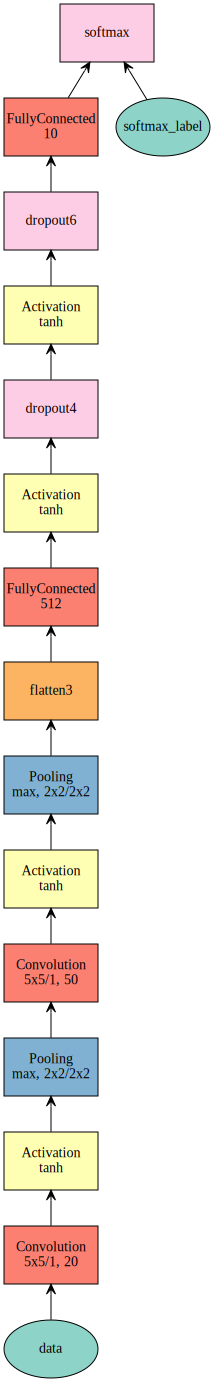

In [35]:
data = mx.sym.var('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=512)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
tanh3 = mx.sym.Dropout(data=tanh3, p=0.5)

fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=256)
tanh4 = mx.sym.Activation(data=tanh3, act_type="tanh")
tanh4 = mx.sym.Dropout(data=tanh4, p=0.5)

fc2 = mx.symbol.FullyConnected(data=tanh4, num_hidden=256)
tanh4 = mx.sym.Activation(data=tanh3, act_type="tanh")
tanh4 = mx.sym.Dropout(data=tanh4, p=0.5)

fc3 = mx.sym.FullyConnected(data=tanh4, num_hidden=10)
# softmax loss
lenetd = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

mx.viz.plot_network(lenetd)

In [36]:
%%time

# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=lenetd, context=mx.gpu())
# train with the same
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01, 'momentum':0.97},
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=25)

INFO:root:Epoch[0] Train-accuracy=0.210554
INFO:root:Epoch[0] Time cost=2.151
INFO:root:Epoch[0] Validation-accuracy=0.847607
INFO:root:Epoch[1] Train-accuracy=0.923391
INFO:root:Epoch[1] Time cost=2.143
INFO:root:Epoch[1] Validation-accuracy=0.974881
INFO:root:Epoch[2] Train-accuracy=0.965835
INFO:root:Epoch[2] Time cost=2.148
INFO:root:Epoch[2] Validation-accuracy=0.983089
INFO:root:Epoch[3] Train-accuracy=0.974330
INFO:root:Epoch[3] Time cost=2.140
INFO:root:Epoch[3] Validation-accuracy=0.985661
INFO:root:Epoch[4] Train-accuracy=0.979144
INFO:root:Epoch[4] Time cost=2.145
INFO:root:Epoch[4] Validation-accuracy=0.988726
INFO:root:Epoch[5] Train-accuracy=0.982959
INFO:root:Epoch[5] Time cost=2.115
INFO:root:Epoch[5] Validation-accuracy=0.988825
INFO:root:Epoch[6] Train-accuracy=0.984042
INFO:root:Epoch[6] Time cost=2.157
INFO:root:Epoch[6] Validation-accuracy=0.989616
INFO:root:Epoch[7] Train-accuracy=0.984941
INFO:root:Epoch[7] Time cost=2.133
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 1min 14s, sys: 8.13 s, total: 1min 22s
Wall time: 58.5 s


If all went well, we should see a higher accuracy metric for predictions made using LeNet. With CNN we should be able to correctly predict around 98% of all test images.

## Summary

In this tutorial, we have learned how to use MXNet to solve a standard computer vision problem: classifying images of hand written digits. You have seen how to quickly and easily build, train and evaluate models such as MLP and CNN with MXNet.

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->

